<a href="https://colab.research.google.com/github/Meaveryway/Backend_AntTech/blob/master/Anime_Scrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dateparser
#!pip3 install fake-useragent

     |████████████████████████████████| 286kB 8.4MB/s 


In [2]:
import os.path
import csv
import re
import requests
from requests import get
from bs4 import BeautifulSoup
#import dateutil.parser as dateParser
import concurrent.futures
import numpy as np
from itertools import repeat
import pandas as pd
import datetime
#from datetime import datetime
import time
from random import randint
import json #to convert from string to list representation, use: json.loads(string)

#from fake_useragent import UserAgent
from urllib.request import Request, urlopen
#ua = UserAgent() # From here we generate a random user agent
proxies = [] # Will contain proxies [ip, port]

import dateparser
import functools
parse = functools.partial(dateparser.parse, date_formats=['%d.%m.%Y']) #to globally change format without specifying it every time
%load_ext google.colab.data_table

In [3]:
DRIVE_PATH = "/content/drive/MyDrive/AniDBrink/"
HEADERS = [
{'User-Agent': 'Mozilla/5.0 (iPhone; CPU iPhone OS 13_3_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148 [FBAN/FBIOS;FBDV/iPhone11,8;FBMD/iPhone;FBSN/iOS;FBSV/13.3.1;FBSS/2;FBID/phone;FBLC/en_US;FBOP/5;FBCR/]'},
{'User-Agent': 'Mozilla/5.0 (Linux; Android 10; moto g(7) power Build/QCOS30.85-18-6; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/86.0.4240.185 Mobile Safari/537.36 [FB_IAB/FB4A;FBAV/294.0.0.39.118;]'},
{'User-Agent': 'Mozilla/5.0 (iPhone; CPU iPhone OS 12_4_6 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148 [FBAN/FBIOS;FBDV/iPhone7,2;FBMD/iPhone;FBSN/iOS;FBSV/12.4.6;FBSS/2;FBID/phone;FBLC/en_US;FBOP/5]'},
{'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7.0; LCJB; rv:11.0) like Gecko'},
{'User-Agent': 'Mozilla/5.0 (Linux; Android 6.0.1; Lenovo-A6020l36 Build/MMB29M) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.93 Mobile Safari/537.36'},
{'User-Agent': 'Mozilla/5.0 (Linux; Android 4.4.2; Lenovo A7600-H Build/KOT49H) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.83 Safari/537.36'},
{'User-Agent': 'Mozilla/5.0 (Linux; U; Android 4.4; ru-ru; Lenovo A5500-H Build/KRT16S) AppleWebKit/534.30 (KHTML, like Gecko) Version/4.4 Mobile Safari/E7FBAF'},
{'User-Agent': 'Mozilla/5.0 (Linux; Android 5.1.1; KFSUWI) AppleWebKit/537.36 (KHTML, like Gecko) Silk/80.5.3 like Chrome/80.0.3987.162 Safari/537.36'},
{'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36'},
{'User-Agent': 'Mozilla/5.0 (Linux; Android 8.0.0; SM-G930F Build/R16NW; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/74.0.3729.157 Mobile Safari/537.36'},
{'User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/65.0.3325.181 Mobile Safari/537.36'},
{'User-Agent': 'Mozilla/5.0 (Linux; Android 7.1.2; DSCS9 Build/NHG47L; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/80.0.3987.149 Safari/537.36'},
{'User-Agent': 'Mozilla/5.0 (Linux; Android 9; SAMSUNG SM-G960U) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/10.2 Chrome/71.0.3578.99 Mobile Safari/537.36'}
]
BASE_URL = "https://anidb.net"
RESULT_PAGE_URL = "https://anidb.net/anime/?h=1&orderby.airdate=0.1&page=XXPGNBXX&type.movie=1&type.ova=1&type.tvseries=1&type.tvspecial=1"

TOKEN = "XXPGNBXX"
NB_RESULT_PAGES = 320

CHINESE_BASE_URL = "https://anidb.net/tag/6152/animetb/?page=XXPGNBXX"
NB_CHINESE = 16

TAIWANESE_BASE_URL = "https://anidb.net/tag/6219/animetb/?page=XXPGNBXX"
NB_TAIWANESE = 1

NORTH_K_BASE_URL = "https://anidb.net/tag/6762/animetb/?page=XXPGNBXX"
NB_NORTH_K = 1

SOUTH_K_BASE_URL = "https://anidb.net/tag/6166/animetb/?page=XXPGNBXX"
NB_SOUTH_K = 5


#### Proxy population

In [ ]:
proxies_req = Request('https://www.sslproxies.org/')
proxies_req.add_header('User-Agent', ua.random)
proxies_doc = urlopen(proxies_req).read().decode('utf8')

soup = BeautifulSoup(proxies_doc, 'html.parser')
proxies_table = soup.find(id='proxylisttable')

# Save proxies in the array
for row in proxies_table.tbody.find_all('tr'):
  proxies.append({
    'ip':   row.find_all('td')[0].string,
    'port': row.find_all('td')[1].string
  })

def random_proxy():
  return randint(0, len(proxies) - 1)

### File writing functions

In [4]:
def write_row_to_anime_list(row):
  file_name = 'ANIME_LIST.csv'
  path = os.path.isfile(file_name)
  if (not path):
    print("\033[96mCreating new file:  {} \033[0m".format(file_name))
    with open(file_name, mode='a') as f:
      writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      writer.writerow(['title', 'category', 'url', 'episodes', 'aired', 'ended'])

  with open(file_name, mode='a') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(row)

def write_row_to_list(row, file_name):
  file_name = file_name
  path = os.path.isfile(file_name)
  if (not path):
    print("\033[96mCreating new file:  {} \033[0m".format(file_name))
    with open(file_name, mode='a') as f:
      writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      writer.writerow(['title', 'category', 'url', 'episodes', 'aired', 'ended'])

  with open(file_name, mode='a') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(row)

def write_row_to_episodes_list(row):
  file_name = DRIVE_PATH + 'EPISODES_LIST.csv'
  path = os.path.isfile(file_name)
  if (not path):
    print("\033[96mCreating new file:  {} \033[0m".format(file_name))
    with open(file_name, mode='a') as f:
      writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      writer.writerow(['anime', 'episode', 'duration', 'date', 'day', 'month', 'week', 'year'])

  with open(file_name, mode='a') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(row)

def write_row_to_genre_list(row):
  file_name = DRIVE_PATH +  'GENRE_LIST.csv'
  path = os.path.isfile(file_name)
  if (not path):
    print("\033[96mCreating new file:  {} \033[0m".format(file_name))
    with open(file_name, mode='a') as f:
      writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      writer.writerow(['anime', 'genre'])
  with open(file_name, mode='a') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(row)

def write_row_to_scraped_list(row):
  file_name = DRIVE_PATH + 'SCRAPED_LIST.csv'
  path = os.path.isfile(file_name)
  if (not path):
    print("\033[96mCreating new file:  {} \033[0m".format(file_name))
    with open(file_name, mode='a') as f:
      writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      writer.writerow(['link'])

  with open(file_name, mode='a') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(row)

def write_row_to_missingno_list(row):
  file_name = DRIVE_PATH + 'MISSINGNO.csv'
  path = os.path.isfile(file_name)
  if (not path):
    print("\033[96mCreating new file:  {} \033[0m".format(file_name))
    with open(file_name, mode='a') as f:
      writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      writer.writerow(['link', 'error'])
  with open(file_name, mode='a') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(row)

def write_df_on_drive(file_name, df):
  path = DRIVE_PATH + file_name
  df.to_csv(path)

def read_df_on_drive(file_name):
  file_path = DRIVE_PATH + file_name
  df = pd.read_csv(file_path)
  return df

# Result page scraping

In [79]:
def scrape_result_page(result_page_url, token, page_number):
  url = result_page_url.replace(token, str(page_number))
  print("Scraping page={} {}\n".format(page_number, url))
  page_content = requests.get(url, headers=HEADERS[0]).text
  soup = BeautifulSoup(page_content)
  table = soup.find('table', {'class': 'animelist'})
  for anime in table.find_all('tr')[1:]:

    title = anime.find('td', {'data-label': 'Title'}).find('a').text
    category = anime.find('td', {'data-label': 'Type'}).text.lower()
    category = "series" if "series" in category else "movie" if "movie" in category else "special" if "special" in category or "ova" in category else "none"
    url = anime.find('td', {'data-label': 'Title'}).find('a')['href']
    url = BASE_URL + url
    episodes = anime.find('td', {'data-label': 'Eps'}).text.replace('\t', '').replace('\n', '')
    aired = anime.find('td', {'data-label': 'Aired'}).text.replace('\t', '').replace('\n', '')
    try:
      aired = str(dateParser.parse(aired).date())
    except:
      pass
    
    ended = anime.find('td', {'data-label': 'Ended'}).text.replace('\t', '').replace('\n', '')
    try:
      ended = str(dateParser.parse(ended).date())
    except Exception:
      pass
    anime = [title, category, url, episodes, aired, ended]
    #write_row_to_anime_list(anime)
    write_row_to_list(anime, FILE_NAME + ".csv")
    print(title)
  #print("Scrapped {} Anime titles.".format(len(animes)))

def scrape_result_pages(base_url, nb_pages):
  pages = np.arange(0, nb_pages, 1)
  print(base_url, nb_pages)
  with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    executor.map(scrape_result_page, repeat(base_url), repeat(TOKEN), pages)

### <font color="yellow">  **Launcher** </font>

In [82]:
FILE_NAME = "SOUTH_K"

In [ ]:
scrape_result_pages(SOUTH_K_BASE_URL, NB_SOUTH_K)
#df = pd.read_csv("ANIME_LIST.csv")
#write_df_on_drive("ANIME_LIST.csv", df)

# Anime Details Extraction

In [ ]:
def get_anime_key(url):
  prefix = re.findall(r"^(.*)/", url)[0] + '/'
  key = url.replace(prefix, "")
  return key

def get_bing_cached_url(key):
  cache_base_url = "https://cc.bingj.com/cache.aspx?q=anidb+3468&d=KEY_1XXX&mkt=en-XA&setlang=en-GB&w=KEY_2XXX"
  query_url = "https://www.bing.com/search?q=anidb+XXXXXXX&search=&form=QBLH".replace("XXXXXXX", str(key))
  req = Request(query_url)
  #print(query_url)
  req.add_header('User-Agent', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.0 Safari/605.1.15')
  page_content = urlopen(req).read().decode('utf8')
  soup = BeautifulSoup(page_content)

  divs = soup.find_all('div', {'class': 'b_attribution'})
  print(divs)
  for div in divs:
    if ".net/anime/" in div.text and str(key) in div.text and "review" not in div.text and 'c_tlbxTrg' in str(div):
      keys = div.get("u")
      # cleanup: 1|5069|4663492871920199|j7ec_BiiCA5ItjWUv-uN4nX5ERrXZSVf
      match = re.findall(r"^(.*?\|)", keys)
      keys = keys.replace(match[0], "", 1)

      match = re.findall(r"^(.*?\|)", keys)
      keys = keys.replace(match[0], "", 1)

      match = re.findall(r"^(.*?\|)", keys)
      key_1 = match[0].replace('|', "", 1)
      keys = keys.replace(match[0], "")

      key_2 = keys

      cache_url = cache_base_url.replace("KEY_1XXX", key_1).replace("KEY_2XXX", key_2)
      return cache_url

def get_bing_first_cached_url(key):
  cache_base_url = "https://cc.bingj.com/cache.aspx?q=anidb+3468&d=KEY_1XXX&mkt=en-XA&setlang=en-GB&w=KEY_2XXX"
  query_url = "https://www.bing.com/search?q=anidb+XXXXXXX&search=&form=QBLH".replace("XXXXXXX", str(key))
  req = Request(query_url)
  #print(query_url)
  req.add_header('User-Agent', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.0 Safari/605.1.15')
  page_content = urlopen(req).read().decode('utf8')
  soup = BeautifulSoup(page_content)

  divs = soup.find_all('div', {'class': 'b_attribution'})
  div = divs[0]
    
  keys = div.get("u")
  # cleanup: 1|5069|4663492871920199|j7ec_BiiCA5ItjWUv-uN4nX5ERrXZSVf
  match = re.findall(r"^(.*?\|)", keys)
  keys = keys.replace(match[0], "", 1)

  match = re.findall(r"^(.*?\|)", keys)
  keys = keys.replace(match[0], "", 1)

  match = re.findall(r"^(.*?\|)", keys)
  key_1 = match[0].replace('|', "", 1)
  keys = keys.replace(match[0], "")

  key_2 = keys

  cache_url = cache_base_url.replace("KEY_1XXX", key_1).replace("KEY_2XXX", key_2)
  return cache_url


In [ ]:
NB_MISSED_ITEMS = 0
SCRAPED_LINKS = []
try:
  df = read_df_on_drive("SCRAPED_LIST.csv")
  SCRAPED_LINKS = df['link'].tolist()
except Exception as e:
  print("No link was scraped before or missing file")

No link was scraped before or missing file


In [ ]:
extract_anime_details('https://anidb.net/anime/726')

# Cleanup

In [ ]:
col_names = ["anime", "episode", "duration", "date", "day", "month", "week", "year", "col9", "col10", "col11"]
df = pd.read_csv('/content/drive/MyDrive/AniDBrink/EPISODES_LIST.csv', names=col_names)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,4,5,6,7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df = df.drop_duplicates(subset=['anime', 'date'])

In [ ]:
df.loc[df['col9'].notnull()]

,anime,episode,duration,date,day,month,week,year,col9,col10,col11
78508,Kono Yo no Hate de Koi o Utau Shoujo Yu-no,22,25m,03Star Twinkle Precure,17,25m,26.05.2019,26,5,21,2019
91199,Waga Seishun no Arcadia: Mugen Kidou SSX,1Shin Mitsubachi Maaya no Bouken,24,25m,01.01.3000,1,1,1,3000,NaN,NaN
133186,Galaxy Angel 3,18,25m,02.02.2003,2,2,05,200Shin Megami Tensei: Devil Children - Light ...,24,25m,15.03.2003
143935,Sasuga no Sarutobi,49,25m,16.10.1983,16,10,41,19Cat`s Eye,28,25m,30.01.1984
162590,Vivy: Fluorite Eye`s Song,3,25m,10.04.2021,10,4,1Youkai Watch (2021),8,25m,28.05.2021,28


In [ ]:
df.iloc[86490:86500]

,anime,episode,duration,date,day,month,week,year,col9,col10,col11
91196,01.3000,1,1,01,3000,NaN,NaN,NaN,NaN,NaN,NaN
91197,Shin Mitsubachi Maaya no Bouken,23,25m,01.01.3000,1,1,01,3000,NaN,NaN,NaN
91198,NaN,02,1983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91199,Waga Seishun no Arcadia: Mugen Kidou SSX,1Shin Mitsubachi Maaya no Bouken,24,25m,01.01.3000,1,1,1,3000,NaN,NaN
91200,Fuku-chan,11,25m,18.01.1983,18,1,03,1983,NaN,NaN,NaN
91201,Waga Seishun no Arcadia: Mugen Kidou SSX,14,25m,26.01.1983,26,1,04,1983,NaN,NaN,NaN
91202,Shin Mitsubachi Maaya no Bouken,25,25m,01.01.3000,1,1,01,3000,NaN,NaN,NaN
91203,Fuku-chan,12,25m,25.01.1983,25,1,04,1983,NaN,NaN,NaN
91204,Waga Seishun no Arcadia: Mugen Kidou SSX,15,25m,02.02.1983,2,2,05,1983,NaN,NaN,NaN
91205,Shin Mitsubachi Maaya no Bouken,26,25m,01.01.3000,1,1,01,3000,NaN,NaN,NaN


In [ ]:
df.loc[df['anime'] == 'Waga Seishun no Arcadia: Mugen Kidou SSX']

In [ ]:
def extract_anime_details(link):
  og_link = link
  if(link not in SCRAPED_LINKS):
    try:
      #proxy_index = random_proxy()
      #proxy = proxies[proxy_index]
      
      #-------------------For using Bing only
      #key = get_anime_key(link)
      #title = title.replace('.', ' ').replace(',', ' ').replace(':', ' ').replace(' ', '-').replace('!', '')
      #link = get_bing_cached_url(link)
      #-----------------------------------------
      print(link)
      req = Request('http://webcache.googleusercontent.com/search?q=cache:'+link)
      req.add_header('User-Agent', 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36')
      req.add_header('Referer', 'https://www.google.com/')
      
      #req.set_proxy(proxy['ip'] + ':' + proxy['port'], 'http')
      page_content = urlopen(req).read().decode('utf8')
      print("ok")
      #page_content = requests.get(link, headers={'User-Agent':ua.random}, proxies = proxy).text
      soup = BeautifulSoup(page_content)
      if "robots" in soup:
        print("----------------------------- Bot Detected")
      #print(soup)
      title = soup.find('div', {'class': 'g_definitionlist'}).find('span', {'itemprop': 'name'}).text
      print(title)
      tags = []
      try:
        tags_list = soup.find('tr', {'class': 'tags'}).find_all('span', {'class': 'tagname'})
        for tag in tags_list:
          tags.append(tag.text)
      except:
        tags.append('none')
      tags = str(tags).replace("'", '"')
      write_row_to_genre_list([title, tags])
      #-----------------------------
      try:
        episodes_table = soup.find('table', {'class': 'eplist'})
        episodes = episodes_table.find_all('tr')[1:]
      except:
        raise Exception("No episodes table")
      for episode in episodes:
        episode_number = episode.find('abbr').text.replace('\t', '').replace('\n', '')#, {'itemprop': 'episodeNumber'}).text.replace('\t', '').replace('\n', '')
        try:
          number = int(episode_number)
          print(number)
        except: #skip this row because it's not an episode (OP, ED or other stuff)
          continue 
        
        try:
          episode_duration = episode.find('td', {'itemprop': 'timeRequired', 'class': 'duration'}).text.replace('\t', '').replace('\n', '')
        except Exception as e: #no duration given
          episode_duration = "none"
        
        
        try:
          episode_date = episode.find('td', {'itemprop': 'datePublished', 'class': 'date airdate'}).text.replace('\t', '').replace('\n', '')
        except Exception as e: #no date given
          episode_date = "01.01.3000"

        episode_day = parse(episode_date).day
        episode_month = parse(episode_date).month
        episode_year = parse(episode_date).year
        episode_week = datetime.date(episode_year, episode_month, episode_day).strftime("%V")
        write_row_to_episodes_list([title, episode_number, episode_duration, episode_date, episode_day, episode_month, episode_week, episode_year])
      write_row_to_scraped_list([og_link])
      time.sleep(randint(2, 4))
        #print("{} {} {} --- {}-{}-{}".format(episode_number, episode_duration, episode_date, episode_day, episode_month, episode_week, episode_year))

    except Exception as e:
      print("----------Error with Anime: {}. Logging in missingno".format(og_link))
      print(e)
      global NB_MISSED_ITEMS
      if str(e) == "No episodes table":
        NB_MISSED_ITEMS = NB_MISSED_ITEMS - 1
        write_row_to_scraped_list([og_link])
      NB_MISSED_ITEMS = NB_MISSED_ITEMS + 1
      #write_row_to_missingno_list([og_link, e])
      #del proxies[proxy_index]
      #print('Proxy ' + proxy['ip'] + ':' + proxy['port'] + ' deleted.')

In [ ]:
def extract_anime_details_batcher(links):
    with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
      executor.map(extract_anime_details, links)    

In [ ]:
def extract_anime_details_temporizer(links, chunk_size): 
  print("Temporizer, Meta extraction.")
  chunks = np.arange(0, len(links), chunk_size)
  print(chunks)
  for chunk in chunks:
    chunk_start = chunk
    chunk_end = (chunk_start + chunk_size) if (chunk_start + chunk_size < len(links)) else (len(links))
    chunk_links = links[chunk_start:chunk_end]
    print("\033[92m" + datetime.datetime.now().strftime("%H:%M:%S") + " Scraping chunk: " + str(chunk_start) + " - " + str(chunk_end) + "\033[0m")
    extract_anime_details_batcher(chunk_links)
    #time.sleep(randint(5, 8))


### <font color="yellow">  **Launcher** </font>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g6IKWg_s0unggcYHv-UpRzjhRcLxC1aeyCCCdIQff0sYeCOl9Fc3XI
Mounted at /content/drive


In [ ]:
NB_MISSED_ITEMS = 0
CHUNK_SIZE = 30

SCRAPED_LINKS = []
try:
  df = read_df_on_drive("SCRAPED_LIST.csv")
  SCRAPED_LINKS = df['link'].tolist()
except Exception as e:
  print("No link was scraped before or missing file")

df = read_df_on_drive("MISSINGNO_NEW.csv")
df_links = df#df[~df['category'].isin(['movie'])] #excluding movies for now
print("Will scrape for {} anime TV series and specials".format(len(df_links)- len(SCRAPED_LINKS)))

#links = df_links['link']
links = df_titles_left['url'].tolist()
#links = links[900:]

start = time.time()
extract_anime_details_temporizer(links, CHUNK_SIZE)
scraping_time = time.time() - start

print('----------------------------------')
print("\033[93mAll scraping completed in {0:.0f}s \033[0m".format(scraping_time))
print("number of scraped animes = {}".format(len(links)))
print("number of missed animes = {}".format(NB_MISSED_ITEMS))

#df_genre = pd.read_csv("GENRE_LIST.csv")
#write_df_on_drive("GENRE_LIST.csv", df_genre)

#df_episodes = pd.read_csv("EPISODES_LIST.csv")
#write_df_on_drive("EPISODES_LIST.csv", df_episodes)

### Proxy rotator

In [ ]:
urls = "https://free-proxy-list.net/"
res = requests.get(urls)
soup = BeautifulSoup(res.text,"html.parser")


tbody = soup.find("tbody")

print(tbody.prettify())

#Left to do:
- ~~Cleaning: remove duplicates and rows with problematic col9, col10 and col11.~~
- for each row, if anime not checked, check the existence of next episode until no more are left with the same anime name. then add to cleaned names.
    - Scrap again what is missing and drop duplicates (old)
- ~~parse dates to int.~~
- Check what titles are missing (because we're always scraping first link by default with bing)
- ~~remove/scrap chineese/korean/taiwaneese productions?~~
---
- ~~Deal with movies separately.~~
- ~~Deal with shorts separately.~~


## Cleanup

In [ ]:
df_missingno = df_missingno.drop_duplicates(subset=['link'])
df_missingno

In [6]:
df = pd.read_csv(DRIVE_PATH + "EPISODES_LIST_Clean.csv")

In [7]:
df.columns

Index(['anime', 'episode', 'duration', 'date', 'day', 'month', 'week', 'year'], dtype='object')

Drop no dates

In [8]:
df_with_date = df[df['year'] < 2030]
df_with_date = df_with_date[df['year'] > 1960]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [9]:
print(len(df))
print(len(df_with_date))
df_with_date.columns

203227
186180


Index(['anime', 'episode', 'duration', 'date', 'day', 'month', 'week', 'year'], dtype='object')

Drop duplicate anime/episode

In [10]:
df_without_dups = df_with_date.drop_duplicates(subset=['anime', 'episode', 'week'])
print(len(df_without_dups))
df_without_dups.head(5)

142995


,anime,episode,duration,date,day,month,week,year
0,86,1,25m,11.04.2021,11,4,14,2021
1,86,2,25m,18.04.2021,18,4,15,2021
2,86,3,25m,25.04.2021,25,4,16,2021
3,86,4,25m,02.05.2021,2,5,17,2021
4,86,5,25m,09.05.2021,9,5,18,2021


Remove non-Japanese productions

In [11]:
li = []
for filename in ['CHINESE', 'TAIWANESE', 'NORTH_K', 'SOUTH_K']:
    df = pd.read_csv(DRIVE_PATH + filename + '.csv', index_col=None, header=0)
    li.append(df)

df_non_japanese = pd.concat(li, axis=0, ignore_index=True)
list_non_japanese = df_non_japanese['title'].tolist()

In [ ]:
list_non_japanese

In [13]:
df_without_foreign = df_without_dups[~df_without_dups['anime'].isin(list_non_japanese)]

In [14]:
print(len(df_without_foreign))
df_without_foreign.head(5)

141134


,anime,episode,duration,date,day,month,week,year
0,86,1,25m,11.04.2021,11,4,14,2021
1,86,2,25m,18.04.2021,18,4,15,2021
2,86,3,25m,25.04.2021,25,4,16,2021
3,86,4,25m,02.05.2021,2,5,17,2021
4,86,5,25m,09.05.2021,9,5,18,2021


Drop shorts (<10min)

In [15]:
df_without_shorts = df_without_foreign.copy()
df_without_shorts['duration'] = df_without_shorts['duration'].str.replace('m', '').astype(int)
df_shorts = df_without_shorts[df_without_shorts['duration'] < 10].reset_index()
df_without_shorts = df_without_shorts[df_without_shorts['duration'] >= 10].reset_index()
print(len(df_without_shorts))
print(len(df_shorts))
df_shorts.tail(10)

120464
20670


,index,anime,episode,duration,date,day,month,week,year
20660,203217,Zumomo to Nupepe,23,5,27.11.2012,27,11,48,2012
20661,203218,Zumomo to Nupepe,24,5,04.12.2012,4,12,49,2012
20662,203219,Zumomo to Nupepe,25,5,08.01.2013,8,1,2,2013
20663,203220,Zumomo to Nupepe,26,5,15.01.2013,15,1,3,2013
20664,203221,Zumomo to Nupepe,27,5,22.01.2013,22,1,4,2013
20665,203222,Zumomo to Nupepe,28,5,29.01.2013,29,1,5,2013
20666,203223,Zumomo to Nupepe,29,5,05.02.2013,5,2,6,2013
20667,203224,Zumomo to Nupepe,30,5,12.02.2013,12,2,7,2013
20668,203225,Zumomo to Nupepe,31,5,19.02.2013,19,2,8,2013
20669,203226,Zumomo to Nupepe,32,5,26.02.2013,26,2,9,2013


Count by week&year

In [16]:
df_count_week_year = df_without_shorts.groupby(['year', 'week']).count().reset_index()
df_count_week_year_shorts = df_shorts.groupby(['year', 'week']).count().reset_index()

In [17]:
df_count_week_year_shorts.tail(5)

,year,week,index,anime,episode,duration,date,day,month
1774,2021,18,9,9,9,9,9,9,9
1775,2021,19,8,8,8,8,8,8,8
1776,2021,20,9,9,9,9,9,9,9
1777,2021,21,5,5,5,5,5,5,5
1778,2021,22,1,1,1,1,1,1,1


In [18]:
df_dice = df_count_week_year[['year', 'week', 'episode']].copy()
df_dice_shorts = df_count_week_year_shorts[['year','week','episode']].copy()
df_dice_shorts.columns = ['year','week','short']
df_merge = pd.merge(df_dice, df_dice_shorts,  how='left', left_on=['year','week'], right_on = ['year','week'])
df_merge

,year,week,episode,short
0,1963,1,3,NaN
1,1963,2,1,NaN
2,1963,3,1,NaN
3,1963,4,1,NaN
4,1963,5,1,NaN
...,...,...,...,...
3059,2021,24,1,NaN
3060,2021,25,1,NaN
3061,2021,26,2,NaN
3062,2021,34,2,NaN


In [19]:
df_merge['date'] = df_merge['year'].map(str)+ '-' +df_merge['week'].map(str) + '-1'
df_merge['short'] = df_merge['short'].apply(lambda x: 0 if np.isnan(x) else x)
df_merge['short'] = df_merge['short'].astype(int)
df_merge

,year,week,episode,short,date
0,1963,1,3,0,1963-1-1
1,1963,2,1,0,1963-2-1
2,1963,3,1,0,1963-3-1
3,1963,4,1,0,1963-4-1
4,1963,5,1,0,1963-5-1
...,...,...,...,...,...
3059,2021,24,1,0,2021-24-1
3060,2021,25,1,0,2021-25-1
3061,2021,26,2,0,2021-26-1
3062,2021,34,2,0,2021-34-1


In [20]:
df_year_sum = df_merge.groupby(['year'])['episode', 'short'].sum().reset_index().copy()
df_year_sum.tail(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,year,episode,short
54,2017,3504,1517
55,2018,3728,1692
56,2019,3280,904
57,2020,2757,979
58,2021,1298,314


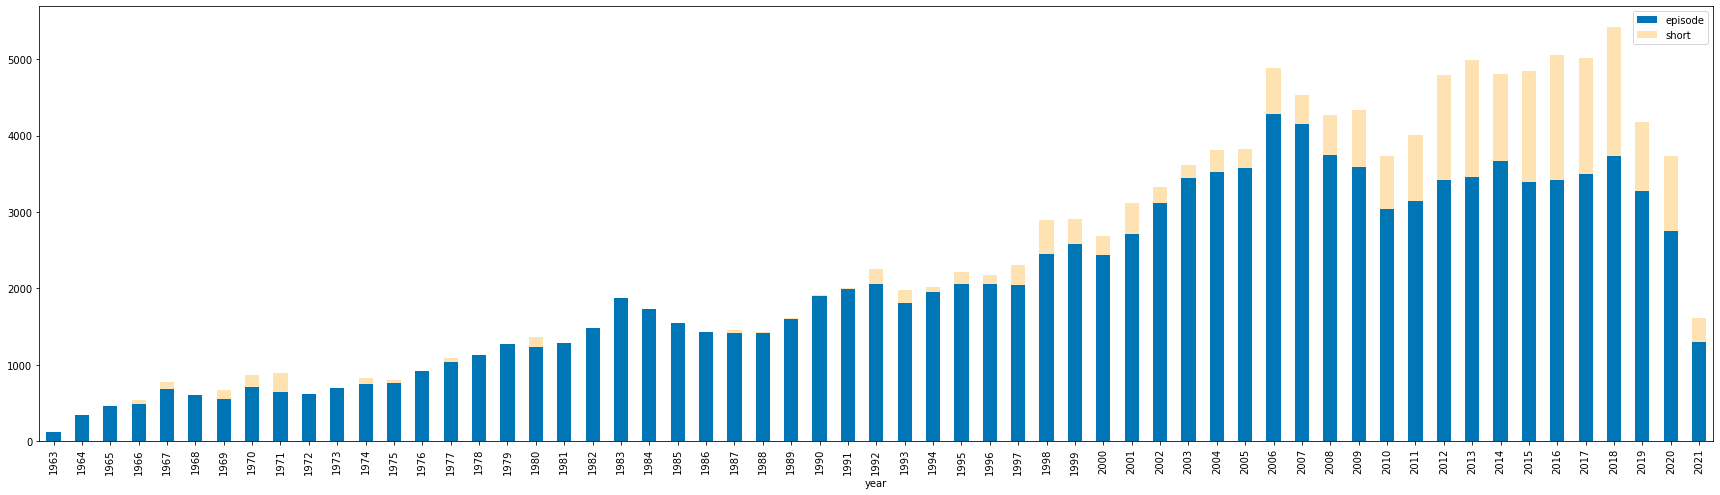

In [21]:
df_year_sum.plot.bar(x='year', stacked=True, color=['#0076b7', (0.99, 0.63, 0, 0.3)], figsize=(30,8))#y='episode'

In [26]:
df_year_avg = df_year_sum.copy()
df_year_avg['episode'] = df_year_avg['episode']/52
df_year_avg.loc[df_year_avg.year == 2021, 'episode'] = df_year_sum.loc[df_year_sum.year == 2021, 'episode']/17
df_year_avg['short'] = df_year_avg['short']/52
df_year_avg.loc[df_year_avg.year == 2021, 'short'] = df_year_sum.loc[df_year_sum.year == 2021, 'short']/17
df_year_avg.tail(40)

,year,episode,short
19,1982,28.423077,0.038462
20,1983,36.000000,0.000000
21,1984,33.288462,0.038462
22,1985,29.711538,0.000000
23,1986,27.519231,0.038462
24,1987,27.250000,0.788462
25,1988,27.173077,0.403846
26,1989,30.653846,0.423077
27,1990,36.596154,0.346154
28,1991,38.403846,0.173077


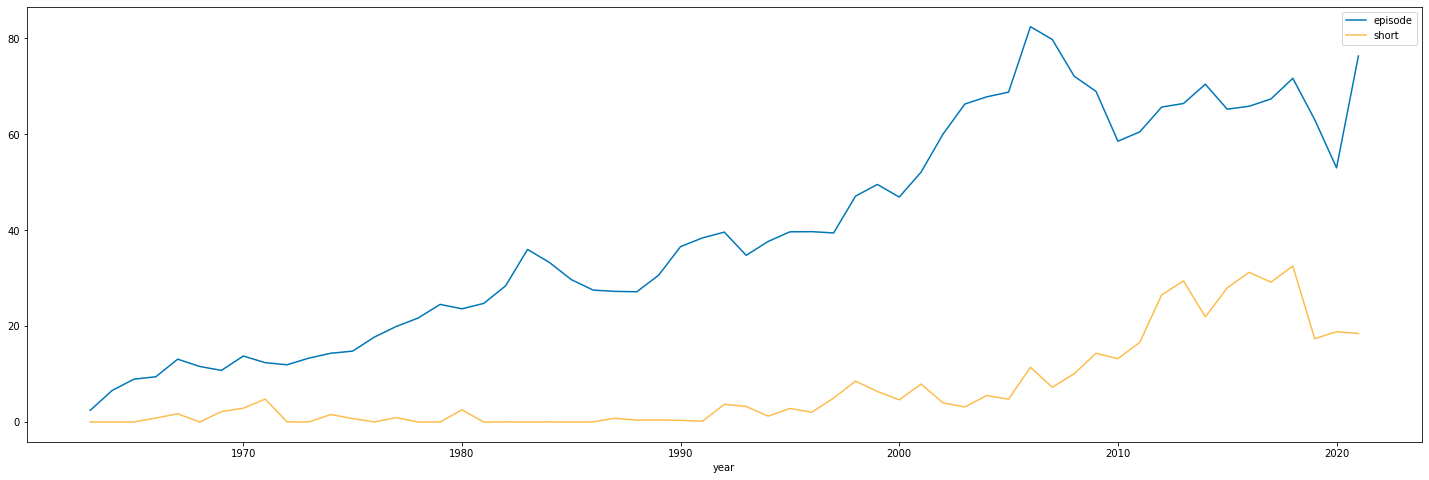

In [24]:
df_year_avg.plot(x='year', color=['#0076b7', (0.99, 0.63, 0, 0.7)], figsize=(25,8))

#### Growth estimation

In [70]:
df_year_sum['episode_cumulative'] = df_year_sum['episode'].cumsum()
df_year_sum['short_cumulative'] = df_year_sum['short'].cumsum()
df_year_sum

,year,episode,short,episode_cumulative,short_cumulative
0,1963,127,1,127,1
1,1964,342,1,469,2
2,1965,465,1,934,3
3,1966,491,43,1425,46
4,1967,682,90,2107,136
5,1968,603,0,2710,136
6,1969,560,113,3270,249
7,1970,716,150,3986,399
8,1971,644,249,4630,648
9,1972,621,2,5251,650


In [ ]:
growth_rate_episodic_episode = np.exp(np.diff(np.log(df_year_sum['episode_cumulative'].tolist()))) - 1
growth_rate_episodic_short = np.exp(np.diff(np.log(df_year_sum['short_cumulative'].tolist()))) - 1
growth_rate.tolist()

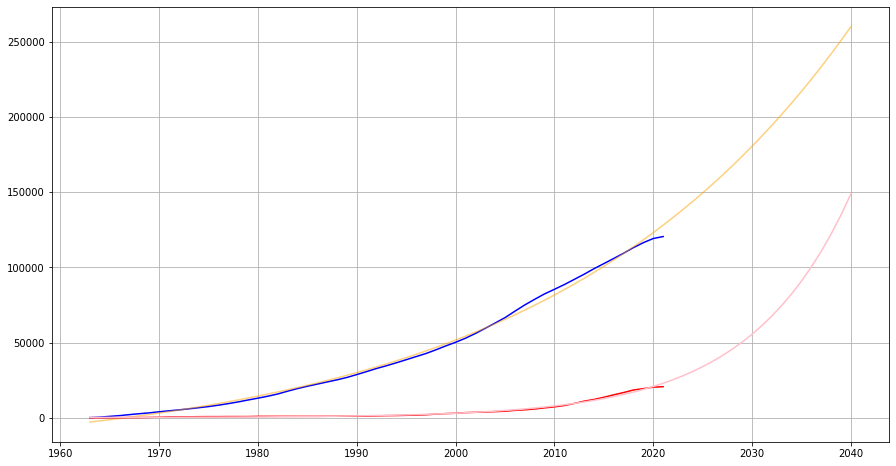

In [85]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,8)
 
x = df_year_sum['year'].to_numpy()
x_scale = x - x[0]
y_episode = df_year_sum['episode_cumulative'].to_numpy()
y_short = df_year_sum['short_cumulative'].to_numpy()

def func(x, a, c, d):
    return a*np.exp(-c*x)+d

# coefficients and curve fit for curve
guess = [1, 1e-8, 1]
popt_episode, pcov_episode = curve_fit(func, x_scale, y_episode, p0=guess, maxfev=10000)
popt_short, pcov_short = curve_fit(func, x_scale, y_short, p0=[1, 0, 1], maxfev=10000)

x1 = np.append(x, [range(2022, 2041)])
x1_scale = x1- x1[0]

y1_episode = func(x1_scale, *popt_episode)
y1_short = func(x1_scale, *popt_short)
 
plt.plot(x, y_episode, 'b')
plt.plot(x1, y1_episode, color=(0.99, 0.63, 0, 0.5))
plt.plot(x, y_short, 'r')
plt.plot(x1, y1_short, 'pink')
plt.grid(True)
plt.savefig('[Growth]Episodes & Shorts.png', dpi=100)
plt.show()

## Anime number

In [27]:
df_nb = pd.read_csv(DRIVE_PATH + "ANIME_NUMBER.csv")
df_nb

,year,number,cumulative
0,1960,0,0
1,1961,1,1
2,1962,2,3
3,1963,8,11
4,1964,3,14
...,...,...,...
56,2016,263,3650
57,2017,242,3892
58,2018,246,4138
59,2019,188,4326


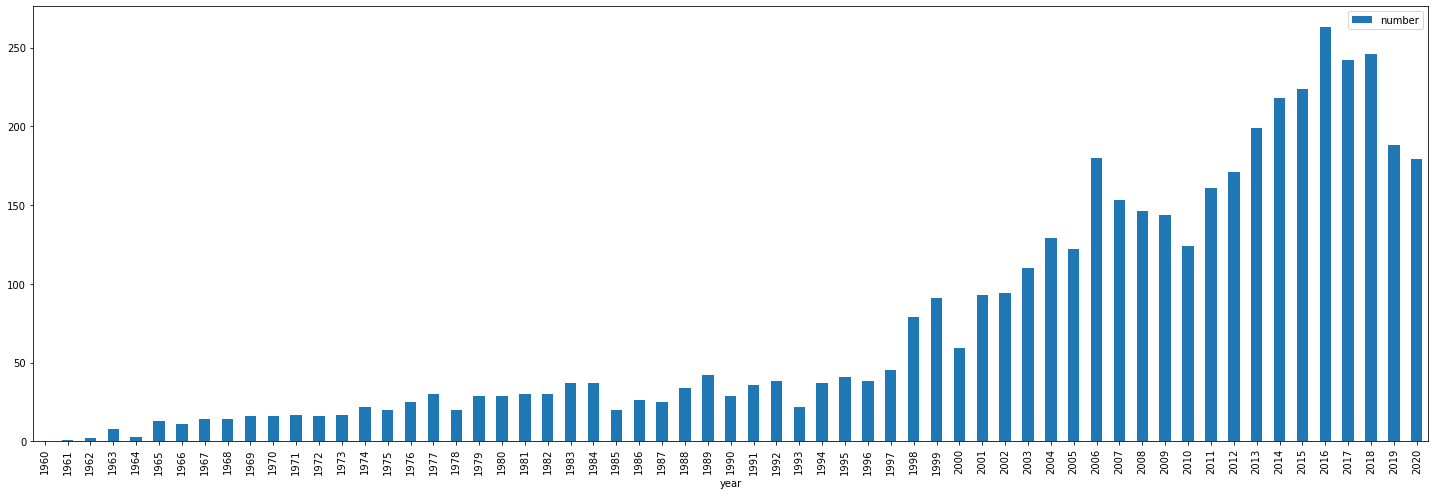

In [28]:
df_nb.plot.bar(x='year', y='number', figsize=(25,8))

In [ ]:
growth_rate_op = np.exp(np.diff(np.log(df_nb['cumulative'].tolist()))) - 1
growth_rate_op.tolist()

In [30]:
df_series = pd.read_csv(DRIVE_PATH + "ANIME_LIST.csv")
df_series = df_series[df_series['category'] == 'series']
df_series = df_series[['title', 'aired']]
df_series['aired'] = df_series['aired'].apply(lambda x: parse(x).year)
print(len(df_series))

4707


In [ ]:
df_series

Drop no dates

In [31]:
df_series = df_series[df_series['aired'] < 2030]
#df_series = df_series[df_series['aired'] > 1950]

In [32]:
print(len(df_series))

4707


Drop duplicate anime/episode

In [33]:
df_series_without_dups = df_series.drop_duplicates(subset=['title', 'aired'])
print(len(df_series_without_dups))
df_series_without_dups.head(5)

4693


,title,aired
255,Instant History,1961
257,Goman-hiki,1962
262,Otogi Manga Calendar,1962
275,Tetsuwan Atom,1963
278,Roppou Yabure-kun,1969


Remove non-Japanese productions

In [34]:
li = []
for filename in ['CHINESE', 'TAIWANESE', 'NORTH_K', 'SOUTH_K']:
    df = pd.read_csv(DRIVE_PATH + filename + '.csv', index_col=None, header=0)
    li.append(df)

df_non_japanese = pd.concat(li, axis=0, ignore_index=True)
list_non_japanese = df_non_japanese['title'].tolist()

In [ ]:
list_non_japanese

In [36]:
df_series_without_foreign = df_series_without_dups[~df_series_without_dups['title'].isin(list_non_japanese)].copy()

In [37]:
print(len(df_series_without_foreign))
df_series_without_foreign.head(5)

4507


,title,aired
255,Instant History,1961
257,Goman-hiki,1962
262,Otogi Manga Calendar,1962
275,Tetsuwan Atom,1963
278,Roppou Yabure-kun,1969


In [38]:
df_series_sum = df_series_without_foreign.groupby(['aired']).count().reset_index().copy()
df_series_sum.tail(5)

,aired,title
56,2017,228
57,2018,237
58,2019,188
59,2020,177
60,2021,150


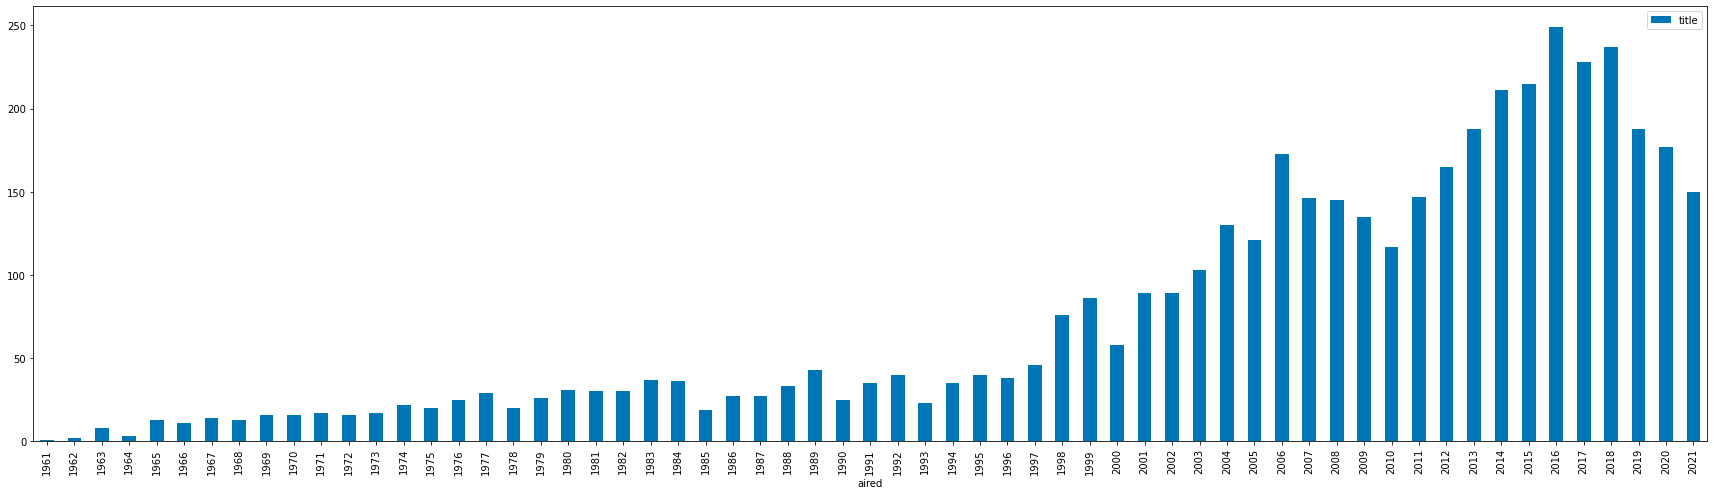

In [105]:
df_series_sum.plot.bar(x='aired', y='title', color='#0076b7', figsize=(30,8))

Growth estimation

In [ ]:
df_series_sum['cumulative'] = df_series_sum['title'].cumsum()
df_series_sum

In [ ]:
growth_rate = np.exp(np.diff(np.log(df_series_sum['cumulative'].tolist()))) - 1
growth_rate.tolist()

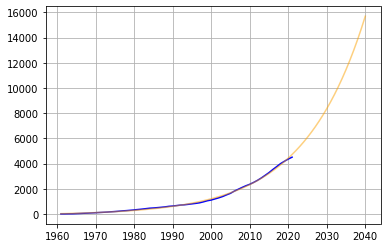

In [68]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
 
x = df_series_sum['aired'].to_numpy()
x_scale = x - x[0]
y = df_series_sum['cumulative'].to_numpy()

def func(x, a, c, d):
    return a*np.exp(-c*x)+d

def func2(t, a, b, c, d, e):
    return a*np.exp(-t/b) + c*np.exp(-t/d) + e

# coefficients and curve fit for curve
guess = [1, 1e-8, 1]
popt, pcov = curve_fit(func, x_scale, y, p0=guess, maxfev=10000)

x1 = np.append(x, [range(2022, 2041)])
x1_scale = x1- x1[0]

y1 = func(x1_scale, *popt)
 
plt.plot(x, y, 'b')
plt.plot(x1, y1, color=(0.99, 0.63, 0, 0.5))
plt.grid(True)
plt.savefig('test2png.png', dpi=100)
plt.show()

In [44]:
df_series_sum_projection = pd.DataFrame({'year': x1, 'cumulative': y1}, columns=['year', 'cumulative'])
df_series_sum_projection['cumulative'] = df_series_sum_projection['cumulative'].apply(lambda x: int(x))
df_series_sum_projection

,year,cumulative
0,1961,20
1,1962,27
2,1963,35
3,1964,43
4,1965,52
...,...,...
75,2036,12202
76,2037,12996
77,2038,13840
78,2039,14739


In [47]:
df_series_sum_projection.loc[0, 'number'] = df_series_sum_projection.loc[0, 'cumulative']
for i in range(1, len(df_series_sum_projection)):
    df_series_sum_projection.loc[i, 'number'] = df_series_sum_projection.loc[i, 'cumulative'] - df_series_sum_projection.loc[i-1, 'cumulative']
df_series_sum_projection['number'] = df_series_sum_projection['number'].apply(lambda x: int(x))
df_series_sum_projection

,year,cumulative,number
0,1961,20,20
1,1962,27,7
2,1963,35,8
3,1964,43,8
4,1965,52,9
...,...,...,...
75,2036,12202,745
76,2037,12996,794
77,2038,13840,844
78,2039,14739,899


## Movies number

In [87]:
df_movies = pd.read_csv(DRIVE_PATH + "ANIME_LIST.csv")
df_movies = df_movies[df_movies['category'] == 'movie']
df_movies = df_movies[['title', 'episodes', 'aired']]
df_movies['aired'] = df_movies['aired'].apply(lambda x: parse(x).year)
print(len(df_movies))

2540


In [88]:
df_movies

,title,episodes,aired
0,Manga Revue Haru,1,1931
1,Adauchi Karasu,1,1934
2,Tarou-san no Kisha,1,1929
3,Sora no Momotarou,1,1931
4,Doubutsu Tonarigumi,1,1941
...,...,...,...
9602,Eiga Sayonara Watashi no Cramer: First Touch,1,2021
9603,Kidou Senshi Gundam: Senkou no Hathaway,3,2021
9604,Sore Ike! Anpanman: Fuwa Fuwa Fuwari to Kumo n...,1,2021
9605,Gekijouban Shoujo Kageki Revue Starlight,1,2021


Drop no dates

In [89]:
df_movies = df_movies[df_movies['aired'] < 2030]
#df_movies = df_movies[df_movies['aired'] > 1950]

In [90]:
print(len(df_movies))

2540


Drop duplicate anime/episode

In [91]:
df_movies_without_dups = df_movies.drop_duplicates(subset=['title', 'aired'])
print(len(df_movies_without_dups))
df_movies_without_dups.head(5)

2522


,title,episodes,aired
0,Manga Revue Haru,1,1931
1,Adauchi Karasu,1,1934
2,Tarou-san no Kisha,1,1929
3,Sora no Momotarou,1,1931
4,Doubutsu Tonarigumi,1,1941


Remove non-Japanese productions

In [92]:
li = []
for filename in ['CHINESE', 'TAIWANESE', 'NORTH_K', 'SOUTH_K']:
    df = pd.read_csv(DRIVE_PATH + filename + '.csv', index_col=None, header=0)
    li.append(df)

df_non_japanese = pd.concat(li, axis=0, ignore_index=True)
list_non_japanese = df_non_japanese['title'].tolist()

In [ ]:
list_non_japanese

In [94]:
df_movies_without_foreign = df_movies_without_dups[~df_movies_without_dups['title'].isin(list_non_japanese)].copy()

In [95]:
print(len(df_movies_without_foreign))
df_movies_without_foreign.head(5)

2348


,title,episodes,aired
0,Manga Revue Haru,1,1931
1,Adauchi Karasu,1,1934
2,Tarou-san no Kisha,1,1929
3,Sora no Momotarou,1,1931
4,Doubutsu Tonarigumi,1,1941


In [96]:
df_movies_without_foreign['episodes'] = df_movies_without_foreign['episodes'].apply(lambda x: 1 if x == 'TBC' else int(x))

In [97]:
df_movies_sum = df_movies_without_foreign.groupby(['aired'])['episodes'].sum().reset_index().copy()
df_movies_sum.tail(5)

,aired,episodes
95,2017,117
96,2018,77
97,2019,105
98,2020,60
99,2021,48


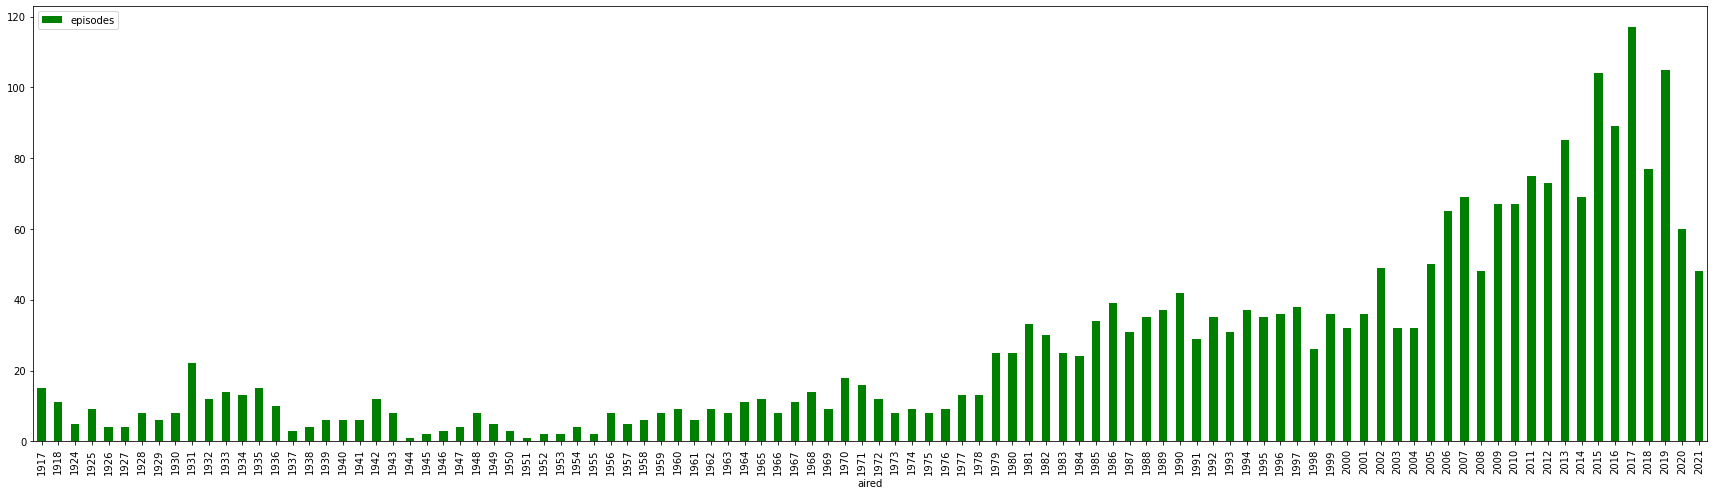

In [98]:
df_movies_sum.plot.bar(x='aired', y='episodes', color='green', figsize=(30,8))

Growth Estimation

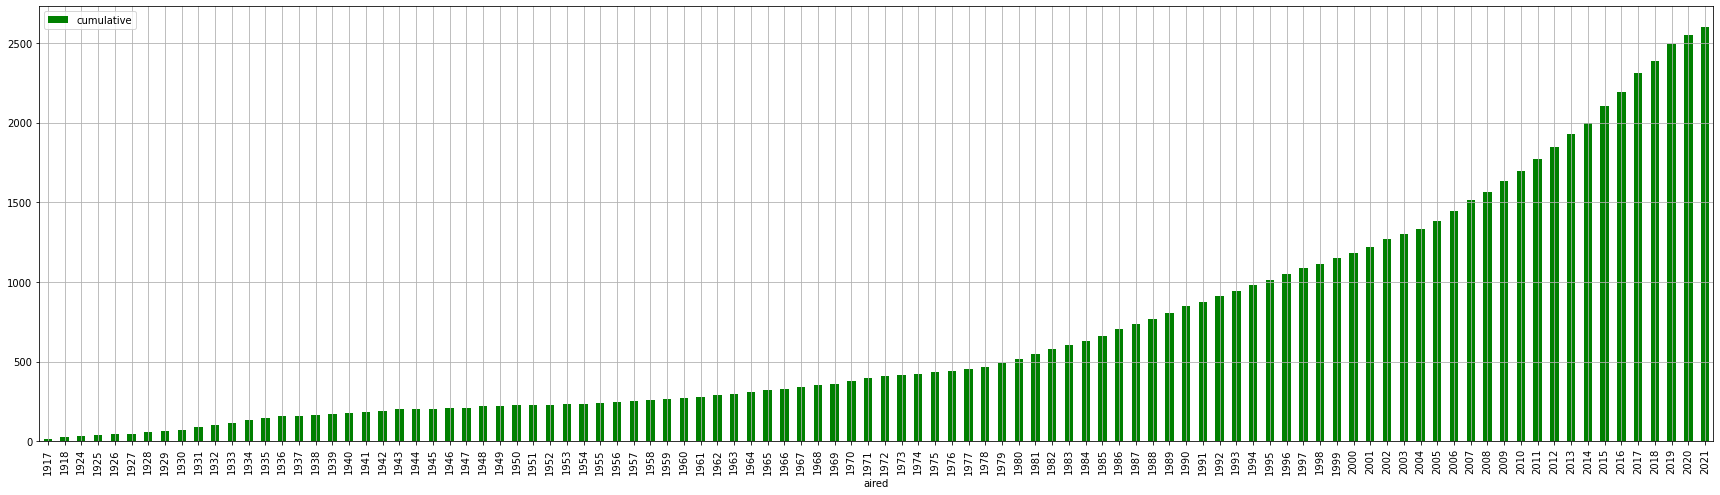

In [103]:
df_movies_sum['cumulative'] = df_movies_sum['episodes'].cumsum()
df_movies_sum.plot.bar(x='aired', y='cumulative', color='green', figsize=(30,8), grid=True)

In [ ]:
movies_growth_rate = np.exp(np.diff(np.log(df_movies_sum['cumulative'].tolist()))) - 1
movies_growth_rate.tolist()

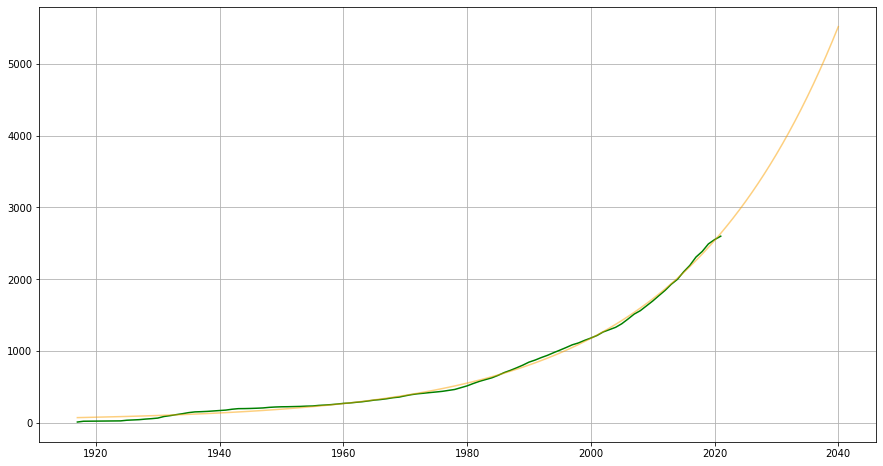

In [101]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
 
x = df_movies_sum['aired'].to_numpy()
x_scale = x - x[0]
y = df_movies_sum['cumulative'].to_numpy()

def func(x, a, c, d):
    return a*np.exp(-c*x)+d

# coefficients and curve fit for curve
guess = [1, 1e-8, 1]
popt, pcov = curve_fit(func, x_scale, y, p0=guess, maxfev=10000)

x1 = np.append(x, [range(2022, 2041)])
x1_scale = x1- x1[0]

y1 = func(x1_scale, *popt)
 
plt.plot(x, y, 'g')
plt.plot(x1, y1, color=(0.99, 0.63, 0, 0.5))
plt.grid(True)
plt.savefig('[Growth]Movies.png', dpi=100)
plt.show()